In [1]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2024 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
###############################################################################

from enum import Enum
import pandas as pd
import numpy as np

import pyomo.environ as pyo
from pyomo.common.collections import ComponentSet, ComponentMap
from pyomo.util.calc_var_value import calculate_variable_from_constraint

import idaes.core.util.scaling as iscale
from pyomo.dae import DerivativeVar
from idaes.core.solvers import petsc
import idaes.logger as idaeslog
import idaes.core.util.model_serializer as ms
from idaes_examples.mod.power_gen.soc_dynamic_flowsheet import (
    SocStandaloneFlowsheet as SocFlowsheet,
)
import matplotlib.pyplot as plt
from idaes.models.control.controller import (
    ControllerType,
    ControllerMVBoundType,
    ControllerAntiwindupType,
)
from IPython.display import SVG, display

# SOC Flowsheet --- PID Control
Author: Douglas Allan

Maintainer: Douglas Allan

Updated: 2024-26-03

## 1. Introduction

This example is designed to demonstrate the use of PI controllers in a complex flowsheet to simulate ramping between different, predetermined setpoints. Steady-state optimization to obtain these setpoints is the subject of a future example. 

## 2. Model Description

The underlying flowsheet consists of a solid oxide cell (SOC) and supporting equipment consisting of electric trim heaters, heat exchangers, a blower for sweep air input, and a condenser to remove excess water from a hydrogen-rich stream. The flowsheet is sized appropriately to produce about 2 kg/s of hydrogen when at its current density limit. Power production mode is then sized to be whatever the net power production is at an average of 400 $\text{mA}/\text{cm}^2$. The trim heaters and heat exchangers are modeled in considerable detail in order to accurately gauge the thermal capacitance of the system. The condenser, on the other hand, is modeled as having perfect control to keep its output temperature at $45^\circ C$. The steam source (presumably an electric boiler) and hydrogen compression train (which would include additional condensers/water traps) are not modeled. 

The `OperatingScenario` `Enum` allows the user to select which initial condition to use. The functions are helper functions for later.

In [2]:
class OperatingScenario(Enum):
    maximum_production = 1
    power_mode = 2


def scale_indexed_constraint(con, sf):
    for idx, c in con.items():
        iscale.constraint_scaling_transform(c, sf)


def set_indexed_variable_bounds(var, bounds):
    for idx, subvar in var.items():
        subvar.bounds = bounds


def create_ramping_eqns(fs, vars, time_scaling_factor=1):
    def rule_ramp(b, t, dvdt, v_ramp):
        return dvdt[t] == v_ramp[t]

    t0 = fs.time.first()

    for var in vars:
        var.unfix()
        shortname = var.name.split(".")[-1]
        blk = var.parent_block()
        dvdt = DerivativeVar(var, wrt=fs.time, initialize=0)
        setattr(blk, "d" + shortname + "dt", dvdt)
        v_ramp = pyo.Var(fs.time, initialize=0)
        setattr(blk, shortname + "_ramp_rate", v_ramp)
        v_ramp_eqn = pyo.Constraint(
            fs.time, rule=lambda b, t: rule_ramp(b, t, dvdt, v_ramp)
        )
        setattr(blk, shortname + "_ramp_rate_eqn", v_ramp_eqn)
        for t in fs.time:
            sv = iscale.get_scaling_factor(var[t], default=1)
            iscale.set_scaling_factor(dvdt[t], sv / time_scaling_factor)
            iscale.set_scaling_factor(v_ramp[t], sv / time_scaling_factor)
            iscale.constraint_scaling_transform(v_ramp_eqn[t], sv / time_scaling_factor)

        v_ramp_eqn[t0].deactivate()
        v_ramp[t0].fix(0)

We begin by ramping from the maximum H2 production setpoint to maximum power production. The ramp starts at one hour, the ramp lasts five minutes, the system is allowed to settle at maximum power mode for two hours, there is another five minute ramp back to maximum H2 production, then the system is given three hours to settle at the end.

In [3]:
operating_scenario = OperatingScenario.maximum_production
m = pyo.ConcreteModel()
t_start = 1 * 60 * 60
t_ramp = 5 * 60
t_settle = 2 * 60 * 60
t_end = 3 * 60 * 60

dt_set = [t_start, t_ramp, t_settle, t_ramp, t_end]

time_set = [sum(dt_set[:j]) for j in range(len(dt_set) + 1)]

# The names here correspond to the row names in
# soec_flowsheet_operating_conditions.csv
# There should be len(time_set) entries here.
# We start simulating a period at maximum production
# in order to confirm the system is at steady state.
if operating_scenario == OperatingScenario.maximum_production:
    setpoints = [
        "maximum_H2",
        "maximum_H2",
        "power",
        "power",
        "maximum_H2",
        "maximum_H2",
    ]
elif operating_scenario == OperatingScenario.power_mode:
    setpoints = [
        "power",
        "power",
        "maximum_H2",
        "maximum_H2",
        "power",
        "power",
    ]
else:
    raise RuntimeError("Please choose a valid operating scenario")

m.fs = SocFlowsheet(
    dynamic=True,
    time_set=time_set,
    time_units=pyo.units.s,
    thin_electrolyte_and_oxygen_electrode=True,
    include_interconnect=True,
)
scaling_log = idaeslog.getLogger("idaes.core.util.scaling")
scaling_log.setLevel(idaeslog.ERROR)
iscale.calculate_scaling_factors(m)

2025-10-27 10:39:12 [WARNING] idaes.models.properties.modular_properties.transport_properties.no_method: Skipping construction of thermal conductivity for phase Liq
2025-10-27 10:39:12 [WARNING] idaes.models.properties.modular_properties.transport_properties.no_method: Skipping construction of dynamic viscosity for phase Liq


Interior point solvers like IPOPT have difficulties when unconstrained solutions occur too close to variable bounds. We therefore strip bounds from some variables that previous simulations have shown to be causing problems.

In [4]:
for t in m.fs.time:
    m.fs.condenser_flash.control_volume.properties_in[t].flow_mol_phase[
        "Liq"
    ].domain = pyo.Reals
    m.fs.condenser_flash.control_volume.properties_in[t].flow_mol_phase[
        "Liq"
    ].bounds = (None, None)
    m.fs.condenser_flash.control_volume.properties_in[t].phase_frac[
        "Liq"
    ].domain = pyo.Reals
    m.fs.condenser_flash.control_volume.properties_in[t].phase_frac["Liq"].bounds = (
        None,
        None,
    )
    for var in [
        m.fs.condenser_flash.control_volume.properties_in[t].log_mole_frac_tdew,
        m.fs.condenser_flash.control_volume.properties_in[t]._mole_frac_tdew,
    ]:
        for idx in var.index_set():
            var[idx].domain = pyo.Reals
            var[idx].bounds = (None, None)

## 3. Process Control

Now we add controllers to the flowsheet. The flowsheet has a helper function, `add_controllers` that adds the controllers if passed a `ComponentMap` that maps manipulated variables (MVs) to tuples that specify the controller. The tuple contains the controller name, the corresponding controlled variable (CV), the type of controller used, the way the controller handles MV bounds, and the antiwindup method.

We restrict ourselves to using P and PI controllers, because derivative action is severely degraded by noise, but PETSc cannot incorporate noise into its simulations.

Controllers can either have no bounds with the `NONE` option (which may result in use of unphysical controls), the `SMOOTH_BOUND` option which uses smooth max and min functions in order to keep the MV within certain thresholds, and the `LOGISTIC` option, which uses a logistic function to keep the MV within bounds. The `LOGISTIC` option is a worse representation of an actual thresholding function than `SMOOTH_BOUND` but may be easier for integrators to handle.

When both variable bounds and integral action are present, integral windup is a problem. If one uses the `NONE` option, no antiwindup is used. If one uses the `CONDITIONAL_INTEGRATION` method, setpoint error does not integrate when the system is at its bounds. This method is relatively easy to implement but the transition between integrating and not integrating causes integrators to slow down significantly. The `BACK_CALCULATION` method subtracts an amount proportional to the difference between the current MV value and the value that the controller would use without variable bounds from the integrated error. This method gives better performance (and is much easier to integrate) than `CONDITIONAL_INTEGRATION`, but it requires a back calculation gain term to be chosen.

In [5]:
antiwindup = ControllerAntiwindupType.BACK_CALCULATION
inner_controller_pairs = ComponentMap()
inner_controller_pairs[m.fs.feed_heater.electric_heat_duty] = (
    "feed_heater_inner_controller",
    m.fs.soc_module.fuel_inlet.temperature,
    ControllerType.PI,
    ControllerMVBoundType.SMOOTH_BOUND,
    antiwindup,
)
inner_controller_pairs[m.fs.sweep_heater.electric_heat_duty] = (
    "sweep_heater_inner_controller",
    m.fs.soc_module.oxygen_inlet.temperature,
    ControllerType.PI,
    ControllerMVBoundType.SMOOTH_BOUND,
    antiwindup,
)
m.fs.add_controllers(inner_controller_pairs)

variable_pairs = ComponentMap()
variable_pairs[m.fs.feed_heater_inner_controller.setpoint] = (
    "feed_heater_outer_controller",
    m.fs.soc_module.fuel_outlet.temperature,
    ControllerType.P,
    ControllerMVBoundType.NONE,
    ControllerAntiwindupType.NONE,
)
variable_pairs[m.fs.sweep_heater_inner_controller.setpoint] = (
    "sweep_heater_outer_controller",
    m.fs.soc_module.oxygen_outlet.temperature,
    ControllerType.P,
    ControllerMVBoundType.NONE,
    ControllerAntiwindupType.NONE,
)
variable_pairs[m.fs.soc_module.potential_cell] = (
    "voltage_controller",
    m.fs.soc_module.fuel_outlet_mole_frac_comp_H2,
    ControllerType.PI,
    ControllerMVBoundType.SMOOTH_BOUND,
    antiwindup,
)
variable_pairs[m.fs.sweep_blower.inlet.flow_mol] = (
    "sweep_blower_controller",
    m.fs.stack_core_temperature,
    ControllerType.P,
    ControllerMVBoundType.SMOOTH_BOUND,
    # antiwindup,
    ControllerAntiwindupType.NONE,
)
variable_pairs[m.fs.makeup_mix.makeup.flow_mol] = (
    "h2_production_rate_controller",
    m.fs.h2_mass_production,
    ControllerType.P,
    ControllerMVBoundType.SMOOTH_BOUND,
    ControllerAntiwindupType.NONE,
    # antiwindup,
)
m.fs.add_controllers(variable_pairs)

Now that the controllers have been added to the flowsheet, they need to be tuned and bounds for the MVs need to be set. Additionally, the `smooth_eps` term used in the `SMOOTH_BOUND` method of handling variable bounds needs to be tuned to the size of the MV. A heuristic is to use $10^{-3}$ or $10^{-4}$ a typical value of the MV.

In [6]:
K = 10e4
tau_I = 15 * 60
tau_D = 5 * 60
m.fs.feed_heater_inner_controller.gain_p.fix(K)
m.fs.feed_heater_inner_controller.gain_i.fix(K / tau_I)
m.fs.feed_heater_inner_controller.mv_lb = 0
m.fs.feed_heater_inner_controller.mv_ub = 10e6
m.fs.feed_heater_inner_controller.smooth_eps = 1000
if antiwindup == ControllerAntiwindupType.BACK_CALCULATION:
    m.fs.feed_heater_inner_controller.gain_b.fix(0.5 / tau_I)

K = 20e4
tau_I = 15 * 60
tau_D = 5 * 60
m.fs.sweep_heater_inner_controller.gain_p.fix(K)
m.fs.sweep_heater_inner_controller.gain_i.fix(K / tau_I)
m.fs.sweep_heater_inner_controller.mv_lb = 0
m.fs.sweep_heater_inner_controller.mv_ub = 10e6
m.fs.sweep_heater_inner_controller.smooth_eps = 1000
if antiwindup == ControllerAntiwindupType.BACK_CALCULATION:
    m.fs.sweep_heater_inner_controller.gain_b.fix(0.5 / tau_I)

K = 0.75
tau_I = 60 * 60
m.fs.feed_heater_outer_controller.gain_p.fix(K)

K = 0.75
tau_I = 60 * 60
m.fs.sweep_heater_outer_controller.gain_p.fix(K)

K = -2
tau_I = 240
m.fs.voltage_controller.gain_p.fix(K)
m.fs.voltage_controller.gain_i.fix(K / tau_I)
m.fs.voltage_controller.mv_lb = 0.7
m.fs.voltage_controller.mv_ub = 1.6
m.fs.voltage_controller.smooth_eps = 0.01
if antiwindup == ControllerAntiwindupType.BACK_CALCULATION:
    m.fs.voltage_controller.gain_b.fix(0.5 / tau_I)

K = -50
tau_I = 40 * 60
m.fs.sweep_blower_controller.gain_p.fix(K)
m.fs.sweep_blower_controller.mv_lb = 1500
m.fs.sweep_blower_controller.mv_ub = 10000
m.fs.sweep_blower_controller.smooth_eps = 10

K = 200
tau_I = 20 * 60
m.fs.h2_production_rate_controller.gain_p.fix(K)
m.fs.h2_production_rate_controller.mv_lb = 1
m.fs.h2_production_rate_controller.mv_ub = 1500
m.fs.h2_production_rate_controller.smooth_eps = 1

Most MVs we want to ramp between the old and new setpoints, but there are a few, especially when changing the controller gain, that we need to step.

In [7]:
step_mvs = ComponentSet([])
step_mvs.add(m.fs.voltage_controller.mv_ref)
step_mvs.add(m.fs.voltage_controller.setpoint)
step_mvs.add(m.fs.makeup_mix.makeup_mole_frac_comp_H2)
step_mvs.add(m.fs.makeup_mix.makeup_mole_frac_comp_H2O)
step_mvs.add(m.fs.h2_production_rate_controller.setpoint)
step_mvs.add(m.fs.h2_production_rate_controller.gain_p)

ramp_mvs = m.fs.manipulated_variables - step_mvs

create_ramping_eqns(m.fs, ramp_mvs, 1)

In the present system of scaling, we cannot guarantee that controller MVs and CVs have had scaling factors set when a controller is scaled, so we need to iterate through the controllers and scale them again after the fact.

In [8]:
for ctrl in m.fs.controller_set:
    iscale.calculate_scaling_factors(ctrl)
    iscale.calculate_scaling_factors(ctrl)

Discretize the time domain. We choose `time_nfe` to be one less than the length of `m.fs.time` so that Pyomo doesn't create any additional time points. After the time discretization equations are created, they are then scaled.

In [9]:
time_nfe = len(m.fs.time) - 1
pyo.TransformationFactory("dae.finite_difference").apply_to(
    m.fs, nfe=time_nfe, wrt=m.fs.time, scheme="BACKWARD"
)
iscale.scale_time_discretization_equations(m, m.fs.time, 1 / (60 * 5))

Load and fix the right initial condition. The `.json.gz` file is generated beforehand by a steady-state optimization. In this case, all these files are pregenerated and committed to the examples repo.

Since we are loading an initial condition from a file, we don't need to solve a steady state problem at `t=0`. Therefore, we need to fix variables corresponding to the differential variables of the system and deactivate certain equations that become degenerate.

In [10]:
if operating_scenario == OperatingScenario.maximum_production:
    ms.from_json(m, fname="max_production.json.gz", wts=ms.StoreSpec.value())
elif operating_scenario == OperatingScenario.power_mode:
    ms.from_json(m, fname="power_mode.json.gz", wts=ms.StoreSpec.value())

m.fs.fix_initial_conditions()

Now that we have loaded an initial condition, we can view it in the flowsheet. The `write_pfd` function iterates through a template `.svg` file and adds numbers to it by comparing the object name in the `.svg` to tags in the flowsheet.

'SOC Dynamic Flowsheet'

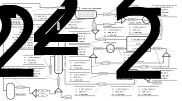

In [11]:
m.fs.write_pfd(fname="soc_dynamic_flowsheet.svg")
display(
    "SOC Dynamic Flowsheet",
    SVG(filename="soc_dynamic_flowsheet.svg"),
)

We create a `ComponentMap` to translate between the column names in `soec_flowsheet_operating_conditions.csv` to the variables in the actual flowsheet so we can use them as setpoints.

In [12]:
alias_dict = ComponentMap()
alias_dict[m.fs.voltage_controller.mv_ref] = "potential"
alias_dict[m.fs.voltage_controller.setpoint] = "soc_fuel_outlet_mole_frac_comp_H2"
alias_dict[m.fs.soc_module.fuel_outlet_mole_frac_comp_H2] = (
    "soc_fuel_outlet_mole_frac_comp_H2"
)
alias_dict[m.fs.h2_production_rate_controller.mv_ref] = "makeup_feed_rate"
alias_dict[m.fs.h2_production_rate_controller.setpoint] = "h2_production_rate"
alias_dict[m.fs.h2_production_rate_controller.gain_p] = (
    "h2_production_rate_controller_gain_p"
)
alias_dict[m.fs.sweep_blower_controller.mv_ref] = "sweep_feed_rate"
alias_dict[m.fs.sweep_blower_controller.setpoint] = "stack_core_temperature"
alias_dict[m.fs.feed_heater_inner_controller.mv_ref] = "feed_heater_duty"
alias_dict[m.fs.feed_heater_outer_controller.mv_ref] = "feed_heater_outlet_temperature"
alias_dict[m.fs.feed_heater_outer_controller.setpoint] = "fuel_outlet_temperature"
alias_dict[m.fs.sweep_heater_inner_controller.mv_ref] = "sweep_heater_duty"
alias_dict[m.fs.sweep_heater_outer_controller.mv_ref] = (
    "sweep_heater_outlet_temperature"
)
alias_dict[m.fs.sweep_heater_outer_controller.setpoint] = "sweep_outlet_temperature"
alias_dict[m.fs.makeup_mix.makeup_mole_frac_comp_H2] = "makeup_mole_frac_comp_H2"
alias_dict[m.fs.makeup_mix.makeup_mole_frac_comp_H2O] = "makeup_mole_frac_comp_H2O"
alias_dict[m.fs.condenser_flash.vap_outlet.temperature] = (
    "condenser_hot_outlet_temperature"
)

alias_dict[m.fs.sweep_recycle_split.recycle_ratio] = "sweep_recycle_ratio"

alias_dict[m.fs.feed_recycle_split.recycle_ratio] = "fuel_recycle_ratio"
alias_dict[m.fs.condenser_split.recycle_ratio] = "vgr_recycle_ratio"

df = pd.read_csv("soec_flowsheet_operating_conditions.csv", index_col=0)

These loops iterate through the flowsheet and fix ramp rate variables or set variables to the appropriate values for the given setpoints.

In [13]:
t0 = m.fs.time.first()
for var in ramp_mvs:
    shortname = var.name.split(".")[-1]
    alias = alias_dict[var]
    blk = var.parent_block()
    v_ramp = getattr(blk, shortname + "_ramp_rate")
    var[t0].fix(float(df[alias][setpoints[0]]))
    for i, t in enumerate(time_set):
        v_ramp[t].fix(
            float(
                (df[alias][setpoints[i]] - df[alias][setpoints[i - 1]])
                / (time_set[i] - time_set[i - 1])
            )
        )

for var in step_mvs:
    shortname = var.name.split(".")[-1]
    alias = alias_dict[var]
    for i, t in enumerate(time_set):
        var[t].fix(float(df[alias][setpoints[i]]))

Here we initialize the controllers. Unit model `.initialize` methods tend to be for steady state optimization, so we manually set variable values and calculate variables from constraints.

In [14]:
# Need to initialize the setpoint for the inner controller or else it starts with the default value 0.5.
m.fs.feed_heater_inner_controller.setpoint[0].value = (
    m.fs.feed_heater_outer_controller.mv_ref[0].value
)
m.fs.sweep_heater_inner_controller.setpoint[0].value = (
    m.fs.sweep_heater_outer_controller.mv_ref[0].value
)
for ctrl in m.fs.controller_set:
    if hasattr(ctrl, "mv_eqn"):
        calculate_variable_from_constraint(ctrl.manipulated_var[0], ctrl.mv_eqn[0])

In [15]:
from idaes.core.util.model_statistics import degrees_of_freedom

assert degrees_of_freedom(m) == 0

Here we run PETSc to integrate the flowsheet with the TS integrator. Because we are loading from a solved flowsheet, in principle we could set `skip_initial=True`. However, due to user error there is sometimes a discrepancy between the setpoints loaded and the initial conditions loaded, so we leave it in. There are many options for PETSc-TS that can be read about in the PETSc documentation.

In [16]:
idaeslog.solver_log.tee = True
results = petsc.petsc_dae_by_time_element(
    m,
    time=m.fs.time,
    keepfiles=True,
    symbolic_solver_labels=True,
    ts_options={
        "--ts_type": "beuler",
        "--ts_dt": 0.1,
        "--ts_rtol": 1e-3,
        # "--ts_adapt_clip":"0.001,3600",
        # "--ksp_monitor":"",
        "--ts_adapt_dt_min": 1e-3,
        "--ts_adapt_dt_max": 3600,
        "--snes_type": "newtontr",
        # "--ts_max_reject": 200,
        # "--snes_monitor":"",
        "--ts_monitor": "",
        "--ts_save_trajectory": 1,
        "--ts_trajectory_type": "visualization",
        "--ts_max_snes_failures": 25,
        # "--show_cl":"",
        "-snes_max_it": 50,
        "-snes_rtol": 0,
        "-snes_stol": 0,
        "-snes_atol": 1e-6,
    },
    skip_initial=False,
    initial_solver="ipopt",
    initial_solver_options={
        "constr_viol_tol": 1e-8,
        "nlp_scaling_method": "user-scaling",
        "linear_solver": "ma57",
        "OF_ma57_automatic_scaling": "yes",
        "max_iter": 300,
        "tol": 1e-8,
        "halt_on_ampl_error": "no",
    },
)
for result in results.results:
    pyo.assert_optimal_termination(result)

component keys that are not exported as part of the NL file.  Skipping.
2025-10-27 10:39:44 [INFO] idaes.solve.petsc-dae: Ipopt 3.13.2: constr_viol_tol=1e-08
2025-10-27 10:39:44 [INFO] idaes.solve.petsc-dae: nlp_scaling_method=user-scaling
2025-10-27 10:39:44 [INFO] idaes.solve.petsc-dae: linear_solver=ma57
2025-10-27 10:39:44 [INFO] idaes.solve.petsc-dae: max_iter=300
2025-10-27 10:39:44 [INFO] idaes.solve.petsc-dae: tol=1e-08
2025-10-27 10:39:44 [INFO] idaes.solve.petsc-dae: halt_on_ampl_error=no
2025-10-27 10:39:44 [INFO] idaes.solve.petsc-dae: option_file_name=C:\Users\dallan\AppData\Local\Temp\tmpk74hymrw_ipopt.opt
2025-10-27 10:39:44 [INFO] idaes.solve.petsc-dae: 
2025-10-27 10:39:44 [INFO] idaes.solve.petsc-dae: Using option file "C:\Users\dallan\AppData\Local\Temp\tmpk74hymrw_ipopt.opt".
2025-10-27 10:39:44 [INFO] idaes.solve.petsc-dae: 
2025-10-27 10:39:44 [INFO] idaes.solve.petsc-dae: 
2025-10-27 10:39:44 [INFO] idaes.solve.petsc-dae: *****************************************

Load certain variables into a dictionary for plotting convenience.

In [17]:
ramp_list = np.array(m.fs.time)[1:]
traj = results.trajectory

time_set = m.fs.time.ordered_data()
tf = time_set[-1]
soec = m.fs.soc_module.solid_oxide_cell

results_dict = {
    "ramp_list": np.array(ramp_list),
    "time": np.array(traj.time),
    "potential": np.array(traj.vecs[str(soec.potential[tf])]),
    "current": np.array(traj.vecs[str(m.fs.soc_module.total_current[tf])]),
    "soec_fuel_inlet_flow": np.array(
        traj.vecs[str(m.fs.soc_module.fuel_inlet.flow_mol[tf])]
    ),
    "soec_oxygen_inlet_flow": np.array(
        traj.vecs[str(m.fs.soc_module.oxygen_inlet.flow_mol[tf])]
    ),
    "fuel_heater_duty": np.array(
        traj.vecs[str(m.fs.feed_heater.electric_heat_duty[tf])]
    ),
    "sweep_heater_duty": np.array(
        traj.vecs[str(m.fs.sweep_heater.electric_heat_duty[tf])]
    ),
    "fuel_inlet_H2": np.array(traj.vecs[str(soec.fuel_inlet.mole_frac_comp[tf, "H2"])]),
    "fuel_inlet_H2O": np.array(
        traj.vecs[str(soec.fuel_inlet.mole_frac_comp[tf, "H2O"])]
    ),
    "fuel_outlet_H2O": np.array(
        traj.vecs[
            str(
                soec.fuel_channel.mole_frac_comp[
                    tf,
                    soec.iznodes.last(),
                    "H2O",
                ]
            )
        ]
    ),
    "sweep_inlet_O2": np.array(
        traj.vecs[str(soec.oxygen_inlet.mole_frac_comp[tf, "O2"])]
    ),
    "sweep_outlet_O2": np.array(
        traj.vecs[
            str(soec.oxygen_channel.mole_frac_comp[tf, soec.iznodes.first(), "O2"])
        ]
    ),
    "H2_production": np.array(traj.vecs[str(m.fs.h2_mass_production[tf])]),
    "fuel_outlet_mole_frac_comp_H2": np.array(
        traj.vecs[str(m.fs.soc_module.fuel_outlet_mole_frac_comp_H2[tf])]
    ),
    "steam_feed_rate": np.array(traj.vecs[str(m.fs.makeup_mix.makeup.flow_mol[tf])]),
    "sweep_feed_rate": np.array(traj.vecs[str(m.fs.sweep_blower.inlet.flow_mol[tf])]),
    "total_electric_power": np.array(traj.vecs[str(m.fs.total_electric_power[tf])]),
    "fuel_inlet_temperature": np.array(
        traj.vecs[str(soec.fuel_channel.temperature_inlet[tf])]
    ),
    "sweep_inlet_temperature": np.array(
        traj.vecs[str(soec.oxygen_channel.temperature_inlet[tf])]
    ),
    "stack_core_temperature": np.array(traj.vecs[str(m.fs.stack_core_temperature[tf])]),
    "fuel_outlet_temperature": np.array(
        traj.vecs[str(soec.fuel_channel.temperature_outlet[tf])]
    ),
    "sweep_outlet_temperature": np.array(
        traj.vecs[str(soec.oxygen_channel.temperature_outlet[tf])]
    ),
    "product_mole_frac_H2": np.array(
        traj.vecs[str(m.fs.condenser_split.inlet.mole_frac_comp[tf, "H2"])]
    ),
    "condenser_outlet_temperature": np.array(
        traj.vecs[
            str(m.fs.condenser_flash.control_volume.properties_out[tf].temperature)
        ]
    ),
    "condenser_heat_duty": np.array(traj.vecs[str(m.fs.condenser_flash.heat_duty[tf])]),
    "temperature_z": np.array(
        [traj.vecs[str(soec.temperature_z[tf, iz])] for iz in soec.iznodes]
    ),
    "fuel_electrode_temperature_deviation_x": np.array(
        [
            traj.vecs[str(soec.fuel_electrode.temperature_deviation_x[tf, 1, iz])]
            for iz in soec.iznodes
        ]
    ),
    "interconnect_temperature_deviation_x": np.array(
        [
            traj.vecs[str(soec.interconnect.temperature_deviation_x[tf, 1, iz])]
            for iz in soec.iznodes
        ]
    ),
    "temperature_z_gradient": np.array(
        [traj.vecs[str(soec.dtemperature_z_dz[tf, iz])] for iz in soec.iznodes]
    ),
    "fuel_electrode_gradient": np.array(
        [
            traj.vecs[str(soec.fuel_electrode.dtemperature_dz[tf, 1, iz])]
            for iz in soec.iznodes
        ]
    ),
    "fuel_electrode_mixed_partial": np.array(
        [
            traj.vecs[str(soec.fuel_electrode.d2temperature_dzdt_dummy[tf, 1, iz])]
            for iz in soec.iznodes
        ]
    ),
    "interconnect_gradient": np.array(
        [
            traj.vecs[str(soec.interconnect.dtemperature_dz[tf, 1, iz])]
            for iz in soec.iznodes
        ]
    ),
    "current_density": np.array(
        [traj.vecs[str(soec.current_density[tf, iz])] for iz in soec.iznodes]
    ),
    "feed_heater_temperature": np.array(
        [
            traj.vecs[str(m.fs.feed_heater.temp_wall_center[tf, z])]
            for z in m.fs.feed_heater.control_volume.length_domain
        ]
    ),
    "sweep_heater_temperature": np.array(
        [
            traj.vecs[str(m.fs.sweep_heater.temp_wall_center[tf, z])]
            for z in m.fs.sweep_heater.control_volume.length_domain
        ]
    ),
    "feed_medium_exchanger_temperature": np.array(
        [
            traj.vecs[str(m.fs.feed_medium_exchanger.temp_wall_center[tf, z])]
            for z in m.fs.feed_medium_exchanger.cold_side.length_domain
        ]
    ),
    "feed_hot_exchanger_temperature": np.array(
        [
            traj.vecs[str(m.fs.feed_hot_exchanger.temp_wall_center[tf, z])]
            for z in m.fs.feed_hot_exchanger.cold_side.length_domain
        ]
    ),
    "sweep_exchanger_temperature": np.array(
        [
            traj.vecs[str(m.fs.sweep_exchanger.temp_wall_center[tf, z])]
            for z in m.fs.sweep_exchanger.cold_side.length_domain
        ]
    ),
}

for controller in m.fs.controller_set:
    ctrl_name = controller.local_name
    results_dict[ctrl_name + "_mv_ref"] = np.array(
        traj.vecs[str(controller.mv_ref[tf])]
    )
    results_dict[ctrl_name + "_setpoint"] = np.array(
        traj.vecs[str(controller.setpoint[tf])]
    )

In [18]:
from pytest import approx

assert pyo.value(m.fs.soc_module.total_current[tf]) == approx(
    -191441360.7471032, rel=1e-3
)
assert pyo.value(m.fs.soc_module.fuel_inlet.temperature[tf]) == approx(
    941.6222233041437, abs=1e-1
)
assert pyo.value(m.fs.soc_module.fuel_outlet.temperature[tf]) == approx(
    985.4832919752795, abs=1e-1
)
assert pyo.value(m.fs.soc_module.oxygen_inlet.temperature[tf]) == approx(
    968.2556310316104, abs=1e-1
)
assert pyo.value(m.fs.soc_module.oxygen_outlet.temperature[tf]) == approx(
    985.7668299902008, abs=1e-1
)
assert pyo.value(m.fs.feed_heater.electric_heat_duty[tf]) == approx(
    790423.6476518983, rel=1e-3
)
assert pyo.value(m.fs.sweep_heater.electric_heat_duty[tf]) == approx(
    1078951.237040893, rel=1e-3
)

Here we plot a number of system variables that we use to gauge system performance. The user is free to adapt this code to view other variables of interest. Note that PETSc preserves trajectories only for Pyomo `Vars`, not named `Expressions`---if you have an `Expression` you want to track, create a `Var` and a simple equality `Constraint` so PETSc will track it. (Don't forget to scale the `Var` and `Constraint`.)

C:\Users\dallan\AppData\Local\Temp\ipykernel_89136\3422529511.py:405: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


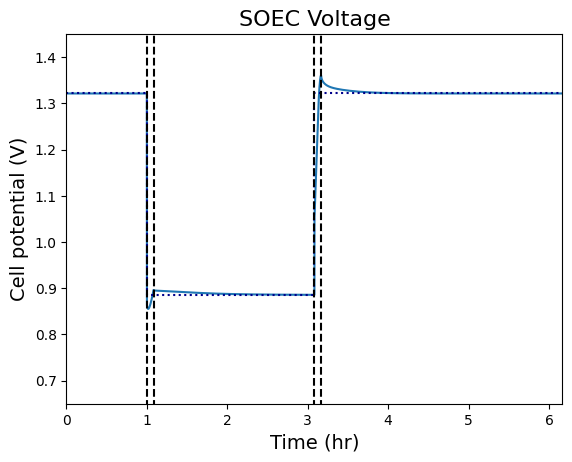

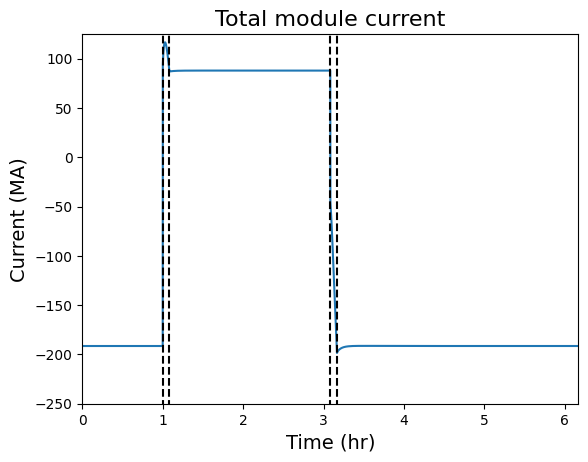

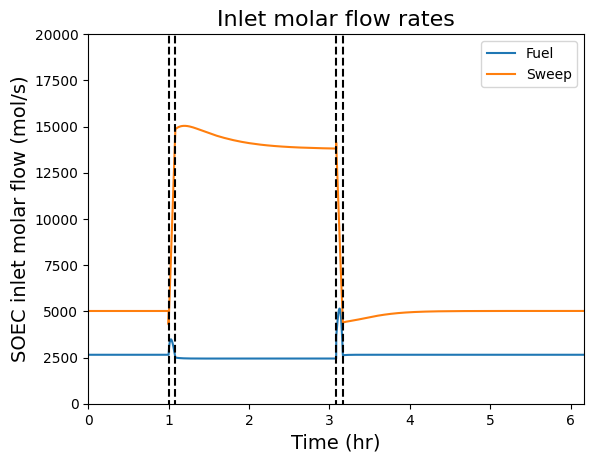

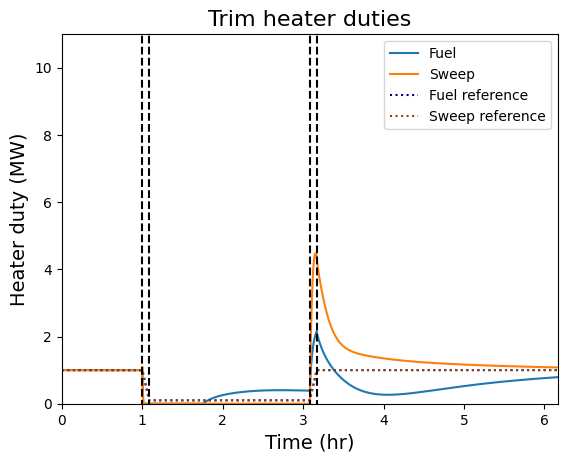

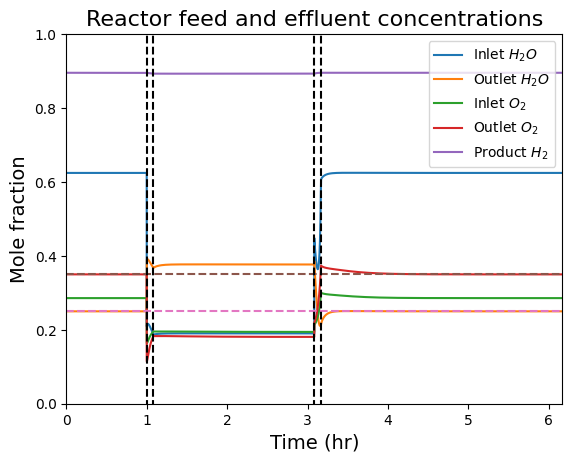

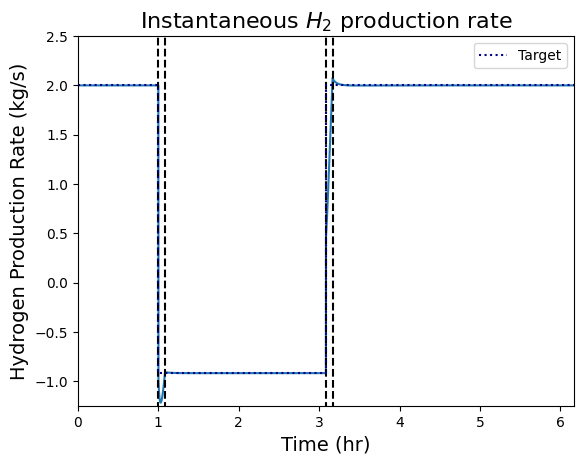

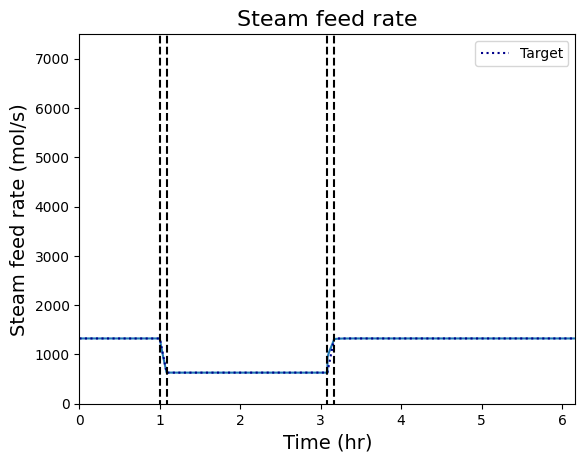

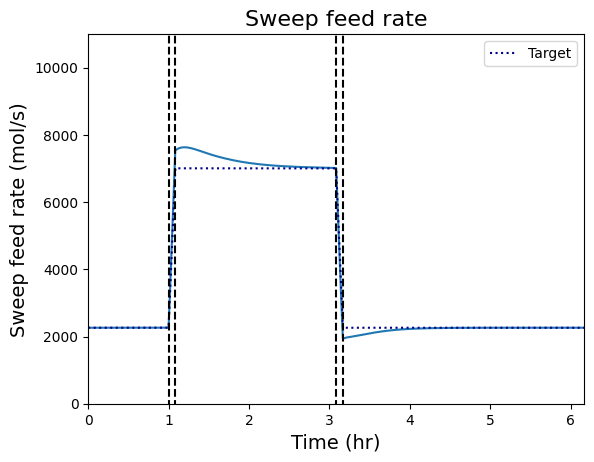

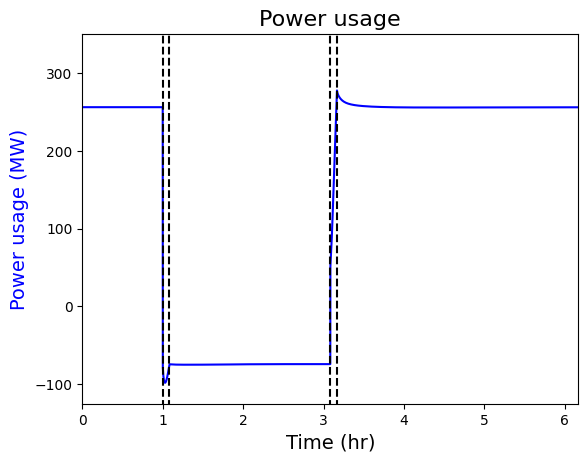

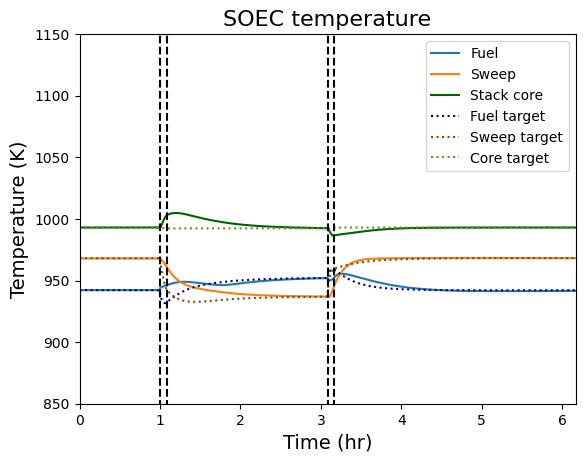

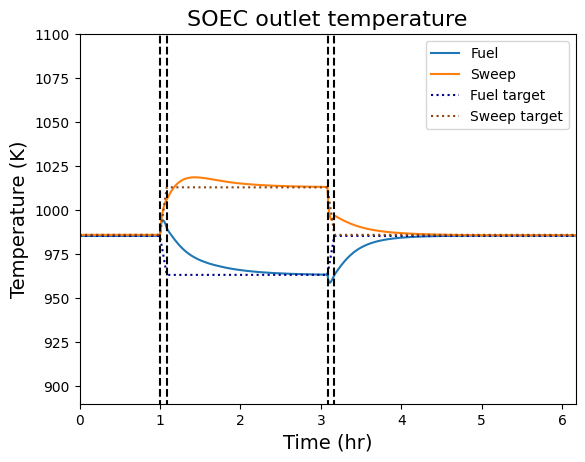

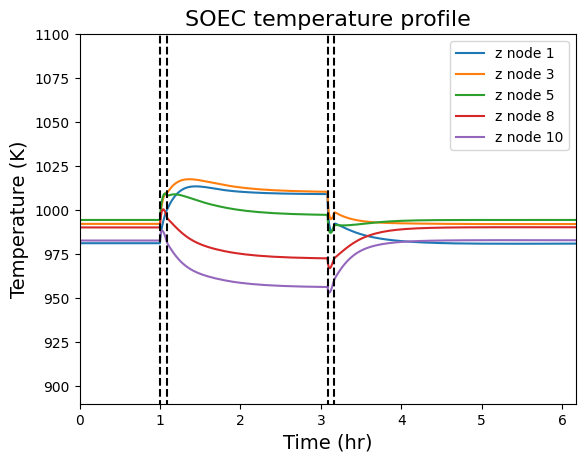

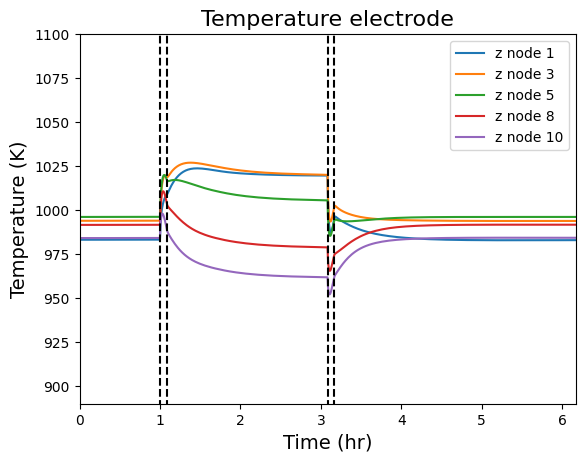

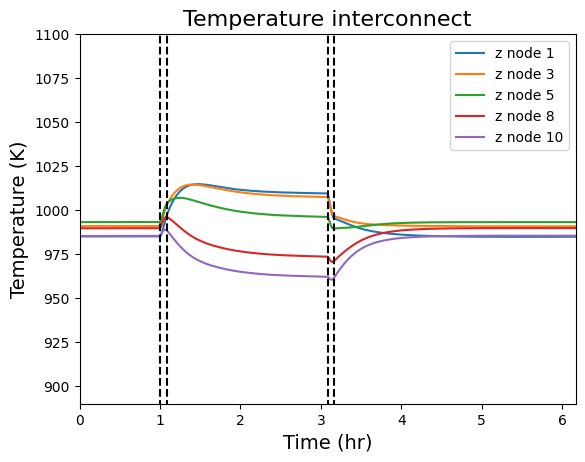

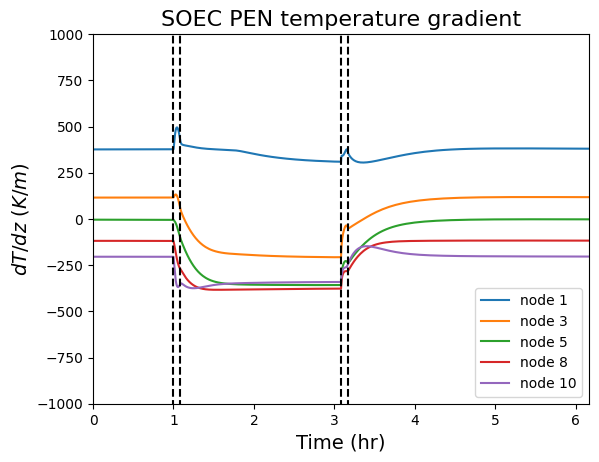

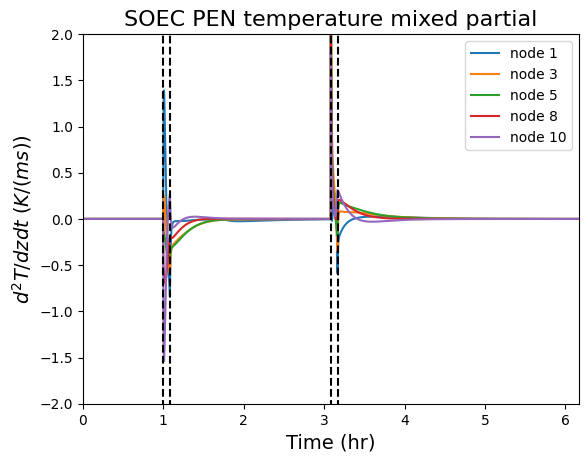

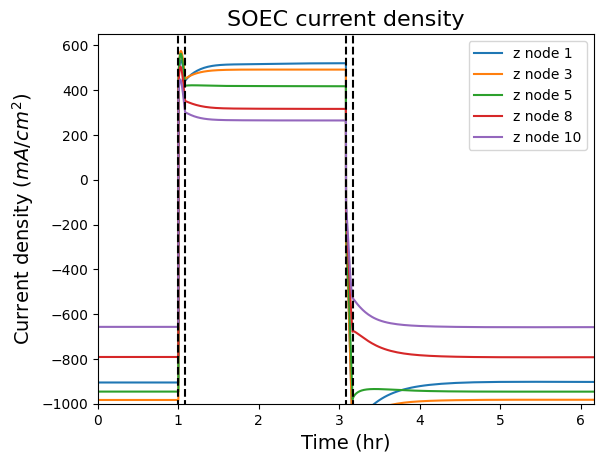

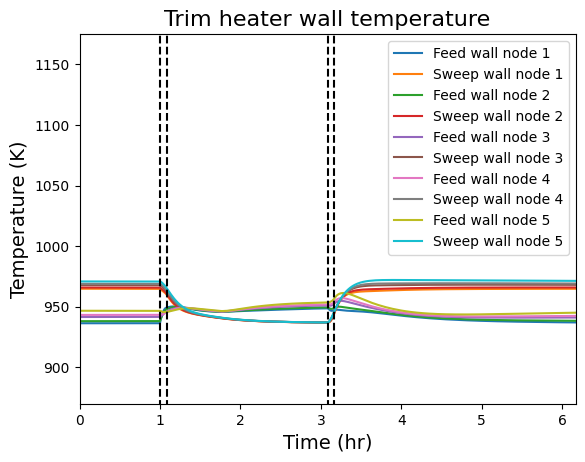

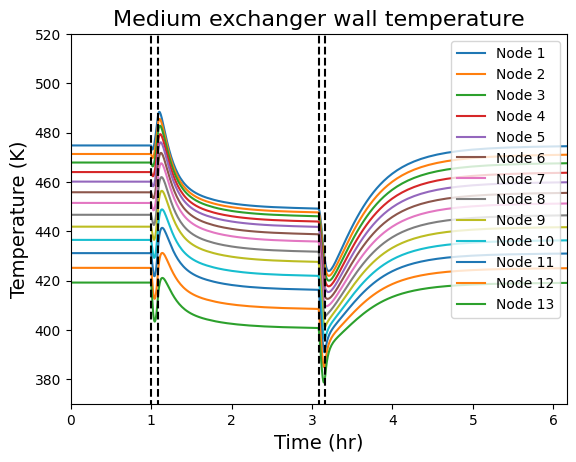

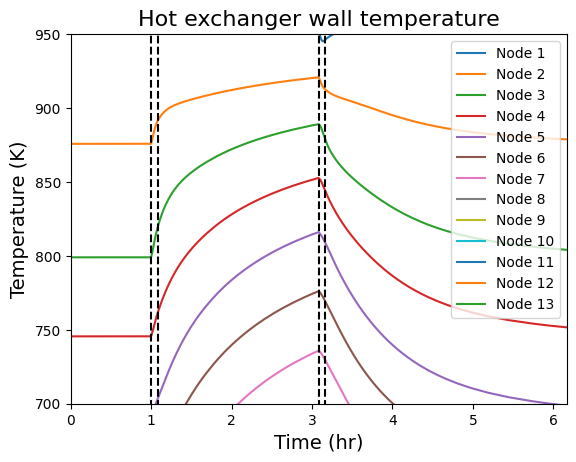

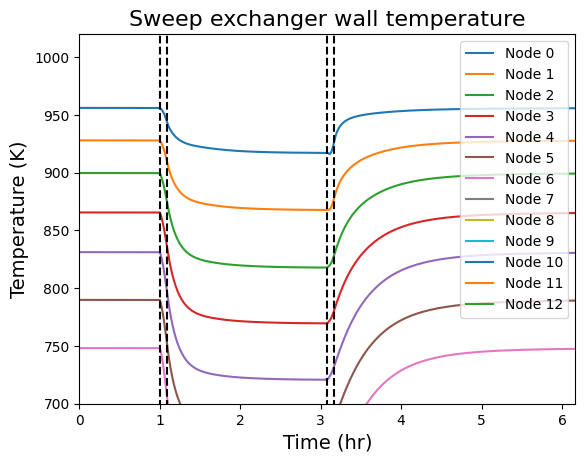

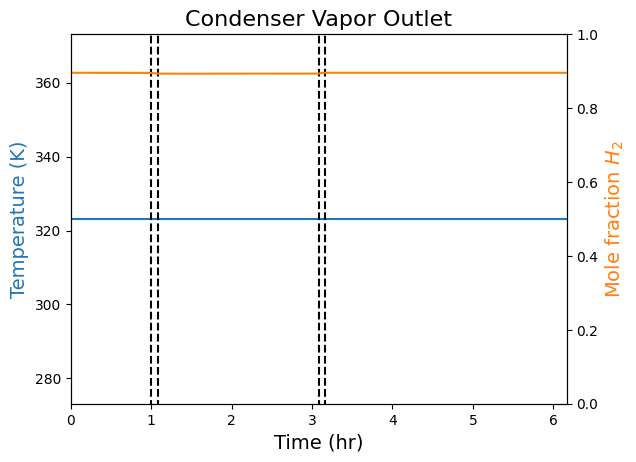

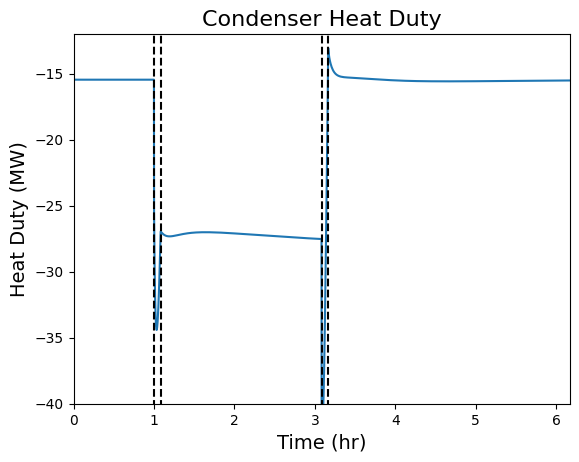

In [19]:
include_PI = True


def _demarcate_ramps(ax, results_dict):
    for tpoint in np.squeeze(results_dict["ramp_list"])[:-1]:
        ax.plot(np.array([tpoint, tpoint]) / 60**2, [-1e6, 1e6], "k--")


for key, value in results_dict.items():
    # Turn n by 1 arrays in into vectors
    results_dict[key] = np.squeeze(value)

demarcate_ramps = lambda ax: _demarcate_ramps(ax, results_dict)

time = results_dict["time"] / 60**2

ax_fontsize = 14
title_fontsize = 16
iz_plot = [1, 3, 5, 8, 10]

fig = plt.figure()
ax = fig.subplots()

ax.plot(time, results_dict["potential"])
if include_PI:
    ax.plot(
        time,
        results_dict["voltage_controller_mv_ref"],
        color="darkblue",
        linestyle="dotted",
    )
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((0.65, 1.45))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Cell potential (V)", fontsize=ax_fontsize)
ax.set_title("SOEC Voltage", fontsize=title_fontsize)

fig = plt.figure()
ax = fig.subplots()

ax.plot(time, results_dict["current"] * 1e-6)
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((-250, 125))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Current (MA)", fontsize=ax_fontsize)
ax.set_title("Total module current", fontsize=title_fontsize)

fig = plt.figure()
ax = fig.subplots()

ax.plot(time, results_dict["soec_fuel_inlet_flow"], label="Fuel")
ax.plot(time, results_dict["soec_oxygen_inlet_flow"], label="Sweep")
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((0, 20000))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("SOEC inlet molar flow (mol/s)", fontsize=ax_fontsize)
ax.set_title("Inlet molar flow rates", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.plot(time, 1e-6 * results_dict["fuel_heater_duty"], label="Fuel", color="tab:blue")
ax.plot(
    time, 1e-6 * results_dict["sweep_heater_duty"], label="Sweep", color="tab:orange"
)
if include_PI:
    ax.plot(
        time,
        1e-6 * results_dict["feed_heater_inner_controller_mv_ref"],
        label="Fuel reference",
        color="darkblue",
        linestyle="dotted",
    )
    ax.plot(
        time,
        1e-6 * results_dict["sweep_heater_inner_controller_mv_ref"],
        label="Sweep reference",
        color="saddlebrown",
        linestyle="dotted",
    )
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((0, 11))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Heater duty (MW)", fontsize=ax_fontsize)
ax.set_title("Trim heater duties", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.plot(time, results_dict["fuel_inlet_H2O"], label="Inlet $H_2O$")
ax.plot(time, results_dict["fuel_outlet_H2O"], label="Outlet $H_2O$")
ax.plot(time, results_dict["sweep_inlet_O2"], label="Inlet $O_2$")
ax.plot(time, results_dict["sweep_outlet_O2"], label="Outlet $O_2$")
ax.plot(time, results_dict["product_mole_frac_H2"], label="Product $H_2$")
ax.plot(time, 0.35 * np.ones(time.shape), "--")
ax.plot(time, 0.25 * np.ones(time.shape), "--")
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((0, 1))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Mole fraction", fontsize=ax_fontsize)
ax.set_title("Reactor feed and effluent concentrations", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.plot(time, results_dict["H2_production"])
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((-1.25, 2.5))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Hydrogen Production Rate (kg/s)", fontsize=ax_fontsize)
ax.set_title("Instantaneous $H_2$ production rate", fontsize=title_fontsize)

if include_PI:
    ax.plot(
        time,
        results_dict["h2_production_rate_controller_setpoint"],
        label="Target",
        color="darkblue",
        linestyle="dotted",
    )
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.plot(time, results_dict["steam_feed_rate"])
if include_PI:
    ax.plot(
        time,
        results_dict["h2_production_rate_controller_mv_ref"],
        label="Target",
        color="darkblue",
        linestyle="dotted",
    )
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((0, 7500))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Steam feed rate (mol/s)", fontsize=ax_fontsize)
ax.set_title("Steam feed rate", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.plot(time, results_dict["sweep_feed_rate"])
if include_PI:
    ax.plot(
        time,
        results_dict["sweep_blower_controller_mv_ref"],
        label="Target",
        color="darkblue",
        linestyle="dotted",
    )
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((0, 11000))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Sweep feed rate (mol/s)", fontsize=ax_fontsize)
ax.set_title("Sweep feed rate", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.plot(time, 1e-6 * results_dict["total_electric_power"], "b", label="Total power")
demarcate_ramps(ax)
ax.set_xlim(time[0], time[-1])
ax.set_ylim((-125, 350))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Power usage (MW)", color="blue", fontsize=ax_fontsize)
ax.set_title("Power usage", fontsize=title_fontsize)

fig = plt.figure()
ax = fig.subplots()

ax.plot(time, results_dict["fuel_inlet_temperature"], label="Fuel", color="tab:blue")
ax.plot(
    time, results_dict["sweep_inlet_temperature"], label="Sweep", color="tab:orange"
)
ax.plot(
    time, results_dict["stack_core_temperature"], label="Stack core", color="darkgreen"
)

if include_PI:
    ax.plot(
        time,
        results_dict["feed_heater_inner_controller_setpoint"],
        label="Fuel target",
        color="darkblue",
        linestyle="dotted",
    )
    ax.plot(
        time,
        results_dict["sweep_heater_inner_controller_setpoint"],
        label="Sweep target",
        color="saddlebrown",
        linestyle="dotted",
    )
    ax.plot(
        time,
        results_dict["sweep_blower_controller_setpoint"],
        label="Core target",
        color="olivedrab",
        linestyle="dotted",
    )

ax.set_xlim(time[0], time[-1])
ax.set_ylim((850, 1150))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)
demarcate_ramps(ax)
ax.set_title("SOEC temperature", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()

ax.plot(time, results_dict["fuel_outlet_temperature"], label="Fuel", color="tab:blue")
ax.plot(
    time, results_dict["sweep_outlet_temperature"], label="Sweep", color="tab:orange"
)
if include_PI:
    ax.plot(
        time,
        results_dict["feed_heater_outer_controller_setpoint"],
        label="Fuel target",
        color="darkblue",
        linestyle="dotted",
    )
    ax.plot(
        time,
        results_dict["sweep_heater_outer_controller_setpoint"],
        label="Sweep target",
        color="saddlebrown",
        linestyle="dotted",
    )

ax.set_xlim(time[0], time[-1])
ax.set_ylim((890, 1100))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)
demarcate_ramps(ax)
ax.set_title("SOEC outlet temperature", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()

for iz in iz_plot:
    ax.plot(time, results_dict["temperature_z"][iz - 1, :], label=f"z node {iz}")

ax.set_xlim(time[0], time[-1])
ax.set_ylim((890, 1100))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)
demarcate_ramps(ax)
ax.set_title("SOEC temperature profile", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()

for iz in iz_plot:
    ax.plot(
        time,
        results_dict["temperature_z"][iz - 1, :]
        + results_dict["fuel_electrode_temperature_deviation_x"][iz - 1, :],
        label=f"z node {iz}",
    )

ax.set_xlim(time[0], time[-1])
ax.set_ylim((890, 1100))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)
demarcate_ramps(ax)
ax.set_title("Temperature electrode", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()

for iz in iz_plot:
    ax.plot(
        time,
        results_dict["temperature_z"][iz - 1, :]
        + results_dict["interconnect_temperature_deviation_x"][iz - 1, :],
        label=f"z node {iz}",
    )

ax.set_xlim(time[0], time[-1])
ax.set_ylim((890, 1100))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)
demarcate_ramps(ax)
ax.set_title("Temperature interconnect", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()

for iz in iz_plot:
    ax.plot(
        time, results_dict["fuel_electrode_gradient"][iz - 1, :], label=f"node {iz}"
    )

ax.set_xlim(time[0], time[-1])
ax.set_ylim((-1000, 1000))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("$dT/dz$ ($K/m$)", fontsize=ax_fontsize)
ax.set_title("SOEC PEN temperature gradient", fontsize=title_fontsize)
demarcate_ramps(ax)
ax.legend()

fig = plt.figure()
ax = fig.subplots()

for iz in iz_plot:
    ax.plot(
        time,
        results_dict["fuel_electrode_mixed_partial"][iz - 1, :],
        label=f"node {iz}",
    )

ax.set_xlim(time[0], time[-1])
ax.set_ylim((-2, 2))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("$d^2T/dzdt$ ($K/(m s)$)", fontsize=ax_fontsize)
ax.set_title("SOEC PEN temperature mixed partial", fontsize=title_fontsize)
demarcate_ramps(ax)
ax.legend()

fig = plt.figure()
ax = fig.subplots()

for iz in iz_plot:
    ax.plot(time, results_dict["current_density"][iz - 1, :] / 10, label=f"z node {iz}")

ax.set_xlim(time[0], time[-1])
# ax.set_ylim((575,875))
ax.set_ylim((-1000, 650))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Current density ($mA/cm^2$)", fontsize=ax_fontsize)
ax.set_title("SOEC current density", fontsize=title_fontsize)
demarcate_ramps(ax)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)
for z in range(results_dict["feed_heater_temperature"].shape[0]):
    ax.plot(
        time,
        results_dict["feed_heater_temperature"][z, :],
        label=f"Feed wall node {z+1}",
    )
    ax.plot(
        time,
        results_dict["sweep_heater_temperature"][z, :],
        label=f"Sweep wall node {z+1}",
    )
ax.set_xlim(time[0], time[-1])
ax.set_ylim((870, 1175))
demarcate_ramps(ax)
ax.set_title("Trim heater wall temperature", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)
for z in range(results_dict["feed_medium_exchanger_temperature"].shape[0]):
    ax.plot(
        time,
        results_dict["feed_medium_exchanger_temperature"][z, :],
        label=f"Node {z + 1}",
    )
ax.set_xlim(time[0], time[-1])
ax.set_ylim((370, 520))
demarcate_ramps(ax)
ax.set_title("Medium exchanger wall temperature", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)

for z in range(results_dict["feed_hot_exchanger_temperature"].shape[0]):
    ax.plot(
        time,
        results_dict["feed_hot_exchanger_temperature"][z, :],
        label=f"Node {z + 1}",
    )
ax.set_xlim(time[0], time[-1])
ax.set_ylim((700, 950))
demarcate_ramps(ax)
ax.set_title("Hot exchanger wall temperature", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize)
for z in range(results_dict["sweep_exchanger_temperature"].shape[0]):
    ax.plot(time, results_dict["sweep_exchanger_temperature"][z, :], label=f"Node {z}")
ax.set_xlim(time[0], time[-1])
ax.set_ylim((700, 1020))
demarcate_ramps(ax)
ax.set_title("Sweep exchanger wall temperature", fontsize=title_fontsize)
ax.legend()

fig = plt.figure()
ax = fig.subplots()
ax2 = ax.twinx()

ax.plot(
    time,
    results_dict["condenser_outlet_temperature"],
    label="Temperature",
    color="tab:blue",
)
ax2.plot(
    time,
    results_dict["product_mole_frac_H2"],
    label="H2 mole fraction",
    color="tab:orange",
)

ax.set_xlim(time[0], time[-1])
ax.set_ylim((273.15, 373.15))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Temperature (K)", fontsize=ax_fontsize, color="tab:blue")
ax2.set_ylim((0, 1))
ax2.set_ylabel("Mole fraction $H_2$", fontsize=ax_fontsize, color="tab:orange")

demarcate_ramps(ax)
ax.set_title("Condenser Vapor Outlet", fontsize=title_fontsize)

fig = plt.figure()
ax = fig.subplots()

ax.plot(time, 1e-6 * results_dict["condenser_heat_duty"])

ax.set_xlim(time[0], time[-1])
ax.set_ylim((-40, -12))
ax.set_xlabel("Time (hr)", fontsize=ax_fontsize)
ax.set_ylabel("Heat Duty (MW)", fontsize=ax_fontsize)

demarcate_ramps(ax)
ax.set_title("Condenser Heat Duty", fontsize=title_fontsize)

plt.show()